# Criando modelo de Machine Learning

## Carregamento dos pacotes iniciais

Apesar de ter exportado um arquivo CSV, vou consultar diretamente o banco de dados ao qual a base existe.

In [1]:
#!pip install mysql-connector-python
#!pip install pyyaml

In [2]:
import pandas as pd
import numpy as np
from mysql.connector import connect, Error
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

## Definição e conexão

Vou usar a leitura de um arquivo yaml, apesar de não ser boa prática armazenar senhas em arquivos estáticos.

In [3]:
with open('login.yml', 'r') as l:
    acesso_yml=yaml.safe_load(l)

conn = connect(**acesso_yml)

In [4]:
base_estudo = pd.read_sql(sql="select * from analise_risco.base_emprestimo_analise", con = conn)
conn.close()
base_estudo.head()

,id_solicitante,id_emprestimo,id_historico,idade_solicitante,salario_solicitante,situacao_propriedade,tempo_trabalhado,motivo,pontuacao,valor_solicitado,taxa_juros,percentual_renda,flag_inadimplencia,anos_primeira_solicitacao,flag_inadimplencia_hist
0,02x9biGh-3gTR,k9lhNtMp-72zH,6EM4uoS2-maX2,23.0,68000.0,Alugada,1.0,Empreendimento,E,14400.0,17.99,0.21,1.0,2,0
1,05AU2u3q-jNEJ,2jgsNDsK-S45I,2nr9qAH9-x2vh,25.0,45000.0,Alugada,0.0,Empreendimento,C,10000.0,12.98,0.22,0.0,2,1
2,05o7RxO7-9LhQ,G7ebJZJb-6GDu,1zlTwsfS-0pan,23.0,65000.0,Alugada,2.0,Pagamento de débitos,B,3600.0,11.49,0.06,0.0,2,0
3,08rX5Qdc-ufb0,0sFrQD5Y-agj2,6rafzTfN-8awI,23.0,45312.0,Alugada,3.0,Educativo,A,13500.0,7.88,0.30,0.0,3,0
4,095kmLry-GPTX,eIoa76FA-d0FH,3ph8dE3U-L5I7,22.0,64000.0,Alugada,6.0,Educativo,A,7000.0,5.79,0.11,0.0,3,0


In [5]:
print('A base de estudo possui {} registros e {} colunas.'.format(base_estudo.shape[0] ,base_estudo.shape[1]))

A base de estudo possui 34485 registros e 15 colunas.


In [6]:
base_estudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34485 entries, 0 to 34484
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_solicitante             34485 non-null  object 
 1   id_emprestimo              34485 non-null  object 
 2   id_historico               34485 non-null  object 
 3   idade_solicitante          34165 non-null  float64
 4   salario_solicitante        34150 non-null  float64
 5   situacao_propriedade       34485 non-null  object 
 6   tempo_trabalhado           33231 non-null  float64
 7   motivo                     34485 non-null  object 
 8   pontuacao                  34485 non-null  object 
 9   valor_solicitado           34154 non-null  float64
 10  taxa_juros                 30859 non-null  float64
 11  percentual_renda           34170 non-null  float64
 12  flag_inadimplencia         34142 non-null  float64
 13  anos_primeira_solicitacao  34485 non-null  int

É possível identificar que temos variáveis com dados nulos

In [7]:
base_estudo.isnull().sum()

id_solicitante                  0
id_emprestimo                   0
id_historico                    0
idade_solicitante             320
salario_solicitante           335
situacao_propriedade            0
tempo_trabalhado             1254
motivo                          0
pontuacao                       0
valor_solicitado              331
taxa_juros                   3626
percentual_renda              315
flag_inadimplencia            343
anos_primeira_solicitacao       0
flag_inadimplencia_hist         0
dtype: int64

In [8]:
base_estudo.id_solicitante.value_counts()

il6n7qzu-0ZOf    1
v8fMpWhK-rCAG    1
DYvnpGn4-Bdgd    1
LaSat9Sk-zLa0    1
BS7QxhQi-0k69    1
                ..
742P2kiF-vDy2    1
48vUpK2L-LahS    1
O6ZUTZMX-ftZc    1
xqBMCHXg-LwMp    1
b6AoXP5G-asDY    1
Name: id_solicitante, Length: 34485, dtype: int64

## Tratamento de dados nulos e análise de outliers

Para esse estudo, decido remover todos os registros que possuem algum dado nulo. Apesar de alguns campos serem possíveis calcular (como por exemplo `valor_solicitado`, `salario_solicitante`, `percentual_renda`) e outros inferir (`tempo_trabalho`). Após ter o modelo pronto, irei usar essa base como uma segunda validação

In [9]:
base_bad = base_estudo.drop(base_estudo.dropna().index)

In [10]:
base_tratada = base_estudo.dropna().copy()

In [11]:
base_tratada.columns

Index(['id_solicitante', 'id_emprestimo', 'id_historico', 'idade_solicitante',
       'salario_solicitante', 'situacao_propriedade', 'tempo_trabalhado',
       'motivo', 'pontuacao', 'valor_solicitado', 'taxa_juros',
       'percentual_renda', 'flag_inadimplencia', 'anos_primeira_solicitacao',
       'flag_inadimplencia_hist'],
      dtype='object')

### Idade solicitante

De acordo com o dicionário de dados, este é o campo com a idade (em anos) do solicitante de empréstimo

In [12]:
base_tratada.idade_solicitante.describe()

count    28882.000000
mean        27.728862
std          6.309004
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: idade_solicitante, dtype: float64

<AxesSubplot:ylabel='idade_solicitante'>

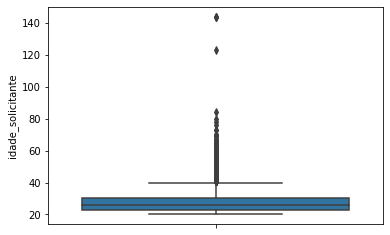

In [13]:
sns.boxplot(data=base_tratada, y='idade_solicitante')

Decido então estabelecer o limite de idade em 80. Acima disso retirarei deste estudo.

Para as idades não informadas, em um primeiro momento eu penso em definir como 20 (que é o mínimo desta base) e acrescentar o tempo trabalhado e assim formar uma idade. Para não ter problema com o modelo, irei separar estes clientes e depois testá-lo no modelo utilizando esta premissa de idade. Farei o mesmo para as idades dispares.

In [14]:
base_tratada.query('idade_solicitante.isnull() or idade_solicitante >= 80', engine='python').index

Int64Index([6641, 8469, 16410, 21550, 27123, 27766], dtype='int64')

In [15]:
base_teste_idade = base_tratada.query('idade_solicitante.isnull() or idade_solicitante >= 80', engine='python')
base_tratada.drop(base_teste_idade.index, inplace=True)

### Salário do solicitante

In [16]:
base_tratada.salario_solicitante.describe().apply("{0:.1f}".format)

count      28876.0
mean       66381.3
std        51434.7
min         4000.0
25%        39381.0
50%        55755.0
75%        80000.0
max      2039784.0
Name: salario_solicitante, dtype: object

<AxesSubplot:ylabel='salario_solicitante'>

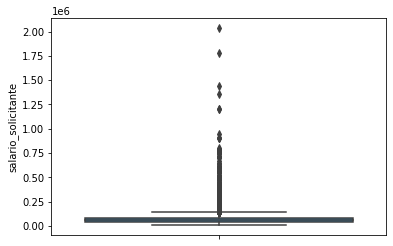

In [17]:
sns.boxplot(data=base_tratada, y='salario_solicitante')

A princípio não irei remover o outlier de salário, verei a relação com as outras variáveis para decidir. Já para os salários não informados, irei utilizar a coluna `percentual_renda` na base _badP_ que criei. De acordo com o dicionário de dados esta coluna representa a _renda percentual entre o valor total do empréstimo e o salário anual_

### Situação Propriedade

De acordo com o dicionário de dados, é situação da propriedade que o solicitante possui. Como esta variável não possui dados nulos e já foi traduzida na origem, irei seguir para a próxima variável

In [18]:
base_tratada.situacao_propriedade.value_counts()

Alugada       14620
Hipotecada    11855
Própria        2204
Outros          197
Name: situacao_propriedade, dtype: int64

### Tempo Trabalhado

O tempo de trabalho, em anos, que o solicitante possui

In [19]:
base_tratada.tempo_trabalhado.describe()

count    28876.000000
mean         4.787644
std          4.154246
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: tempo_trabalhado, dtype: float64

<AxesSubplot:ylabel='tempo_trabalhado'>

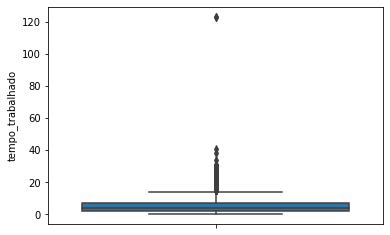

In [20]:
sns.boxplot(data=base_tratada, y='tempo_trabalhado')

Temos pelo menos duas situações que necessitam de correção:
1. Tempo de trabalho maior ou igual ao tempo de vida
1. Tempo de trabalho nulo

In [21]:
ix_tempo_invalido = base_tratada.query('tempo_trabalhado >= idade_solicitante', engine='python').index

<AxesSubplot:ylabel='tempo_trabalhado'>

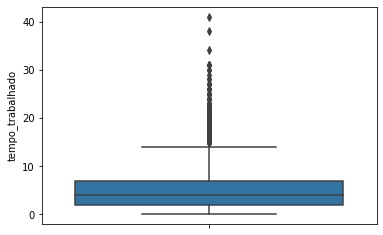

In [22]:
sns.boxplot(data=base_tratada.drop(index=ix_tempo_invalido), y='tempo_trabalhado')

In [23]:
base_teste_tempo_trabalhado = base_tratada.loc[ix_tempo_invalido]
base_tratada.drop(index=ix_tempo_invalido, inplace=True)

### Motivo

Motivo do empréstimo

In [24]:
base_tratada.motivo.value_counts()

Educativo               5728
Médico                  5318
Empreendimento          5022
Pessoal                 4899
Pagamento de débitos    4595
Melhora do lar          3210
Outros                   102
Name: motivo, dtype: int64

### Pontuação

É a pontuação de empréstimos

In [25]:
base_tratada.pontuacao.value_counts()

A    9451
B    9188
C    5732
D    3257
E     874
F     211
      102
G      59
Name: pontuacao, dtype: int64

In [26]:
base_tratada.query('pontuacao == ""')

,id_solicitante,id_emprestimo,id_historico,idade_solicitante,salario_solicitante,situacao_propriedade,tempo_trabalhado,motivo,pontuacao,valor_solicitado,taxa_juros,percentual_renda,flag_inadimplencia,anos_primeira_solicitacao,flag_inadimplencia_hist
396,cJgwA3tE-AY4M,JLGJfrzw-MGWa,2HTnbMk1-nQeW,38.0,48000.0,Hipotecada,23.0,Médico,,18250.0,11.11,0.19,0.0,4,
852,KoyFBbks-gi45,7O6L2fZB-oDZe,5krLhjYZ-fpEb,33.0,21000.0,Alugada,0.0,Outros,,12000.0,10.39,0.40,1.0,9,0
916,lyUgjRNf-Hjp9,AJBQgakp-AMbu,6Z79o9wP-uPWl,27.0,44000.0,Hipotecada,2.0,Médico,,7500.0,10.59,0.14,0.0,3,0
1235,sQDATdCY-DIaN,D6Xyg742-6LfN,3gifNtWw-QoxQ,38.0,200000.0,Hipotecada,2.0,Outros,,15000.0,10.37,0.24,0.0,6,0
1275,tgqDm8dC-dirP,9kbfXZw4-Zpu8,0Fn8LtfN-jgvy,38.0,22000.0,Outros,2.0,Pagamento de débitos,,25000.0,13.43,0.17,0.0,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31844,NvSSqfRK-KBNw,wCJSKXkH-dNff,eR6vMeph-tUPf,23.0,50000.0,Alugada,0.0,Empreendimento,,5000.0,12.98,0.14,1.0,3,
32442,xc3EN6rE-DrN9,NdrT5OeK-EOZx,fXj5Mlny-9O97,24.0,35000.0,Hipotecada,3.0,Outros,,35000.0,13.99,0.21,0.0,14,1
33146,QGd0EgPs-qD56,0kaEza3S-6n0H,xnq6PMYC-sf0Y,24.0,56000.0,Alugada,0.0,Empreendimento,,15000.0,15.33,0.39,0.0,3,
33693,RCuhJUxp-BUvw,lC7xOxg4-S49I,8T6ZIyLK-jc0e,22.0,36000.0,Alugada,1.0,Educativo,,15000.0,12.84,0.33,1.0,3,


Como não sabemos ainda a forma de classificação desta pontuação, decido retirar os registros inválidos

In [27]:
ix_pontuacao_invalida = base_tratada.query('pontuacao == ""').index
base_teste_pontuacao = base_tratada.loc[ix_pontuacao_invalida]
base_tratada.drop(index=ix_pontuacao_invalida, inplace=True)

### Valor solicitado

In [28]:
base_tratada.valor_solicitado.describe()

count    28772.000000
mean      9655.593111
std       6327.386227
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12500.000000
max      35000.000000
Name: valor_solicitado, dtype: float64

### Taxa de juros

<AxesSubplot:ylabel='taxa_juros'>

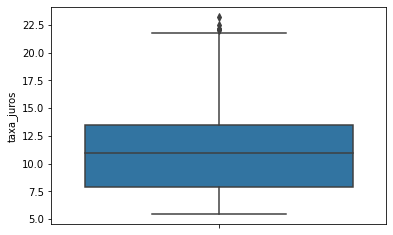

In [29]:
sns.boxplot(data=base_tratada, y='taxa_juros')

### Percentual de renda

<AxesSubplot:ylabel='percentual_renda'>

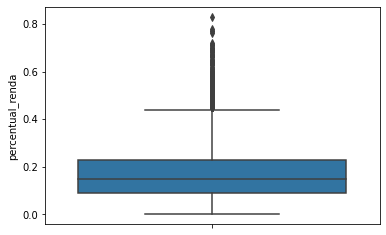

In [30]:
sns.boxplot(data=base_tratada, y='percentual_renda')

Empréstimos pesados...

### Flag inadimplencia

In [31]:
base_tratada.flag_inadimplencia.value_counts()

0.0    22526
1.0     6246
Name: flag_inadimplencia, dtype: int64

In [32]:
base_tratada.flag_inadimplencia.unique()

array([1., 0.])

### Anos primeira solicitação

<AxesSubplot:ylabel='anos_primeira_solicitacao'>

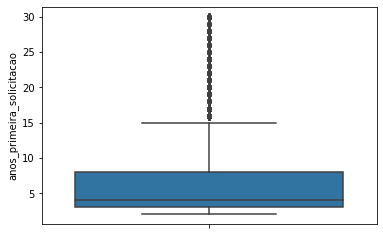

In [33]:
sns.boxplot(data=base_tratada, y='anos_primeira_solicitacao')

In [34]:
base_tratada.query("anos_primeira_solicitacao >= idade_solicitante")

,id_solicitante,id_emprestimo,id_historico,idade_solicitante,salario_solicitante,situacao_propriedade,tempo_trabalhado,motivo,pontuacao,valor_solicitado,taxa_juros,percentual_renda,flag_inadimplencia,anos_primeira_solicitacao,flag_inadimplencia_hist


### Flag inadimplencia histórica

In [35]:
base_tratada.flag_inadimplencia_hist.value_counts()

0    23576
1     5117
        79
Name: flag_inadimplencia_hist, dtype: int64

Vou replicar essas informações

In [36]:
base_tratada.query('flag_inadimplencia_hist == ""')[['flag_inadimplencia', 'flag_inadimplencia_hist']]

,flag_inadimplencia,flag_inadimplencia_hist
398,0.0,
501,1.0,
1260,1.0,
1436,0.0,
2832,0.0,
...,...,...
30301,0.0,
31448,1.0,
31607,0.0,
33548,1.0,


In [37]:
ix_flag_inad_hist_nula = base_tratada.query('flag_inadimplencia_hist == ""').index

In [38]:
base_tratada.loc[ix_flag_inad_hist_nula, 'flag_inadimplencia_hist'] = base_tratada.loc[ix_flag_inad_hist_nula, 'flag_inadimplencia'].astype('int64')

In [39]:
base_tratada.flag_inadimplencia_hist = base_tratada.flag_inadimplencia_hist.astype('int64')

In [40]:
base_tratada.flag_inadimplencia_hist.value_counts()

0    23632
1     5140
Name: flag_inadimplencia_hist, dtype: int64

## Visualização dos dados

Vou fazer uma análise visual entre as colunas e a variável target. Agora as colunas de identificação não serão necessárias

In [41]:
base_tratada.drop(columns=['id_solicitante', 'id_emprestimo', 'id_historico'], inplace=True)

In [42]:
base_tratada.columns

Index(['idade_solicitante', 'salario_solicitante', 'situacao_propriedade',
       'tempo_trabalhado', 'motivo', 'pontuacao', 'valor_solicitado',
       'taxa_juros', 'percentual_renda', 'flag_inadimplencia',
       'anos_primeira_solicitacao', 'flag_inadimplencia_hist'],
      dtype='object')

Vou primeiro explorar as variáveis categóricas e depois as numéricas

### Categóricas

#### Situação da propriedade

In [43]:
pd.crosstab(index = base_tratada['situacao_propriedade'],
            columns = base_tratada['flag_inadimplencia'], 
            normalize = 'index') * 100

flag_inadimplencia,0.0,1.0
situacao_propriedade,,
Alugada,68.754287,31.245713
Hipotecada,87.378394,12.621606
Outros,72.000000,28.000000
Própria,93.175614,6.824386


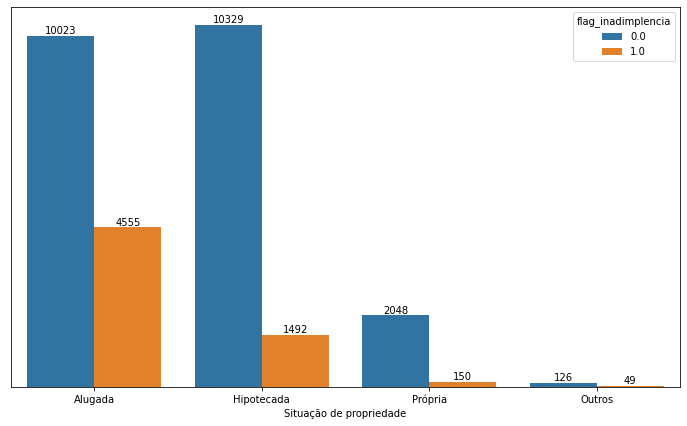

In [44]:
plt.figure(figsize=(12,7))
ax = sns.countplot(data=base_tratada, x='situacao_propriedade', hue='flag_inadimplencia')
ax.get_yaxis().set_visible(False)
plt.xlabel('Situação de propriedade')
ax.bar_label(container = ax.containers[0])
ax.bar_label(container = ax.containers[1])

plt.show()

#### Motivo da solicitação

In [45]:
pd.crosstab(index = base_tratada['motivo'],
            columns = base_tratada['flag_inadimplencia'], 
            normalize = 'index') * 100

flag_inadimplencia,0.0,1.0
motivo,,
Educativo,82.959720,17.040280
Empreendimento,85.358069,14.641931
Melhora do lar,74.391765,25.608235
Médico,73.134891,26.865109
Outros,60.563380,39.436620
Pagamento de débitos,71.634615,28.365385
Pessoal,80.237316,19.762684


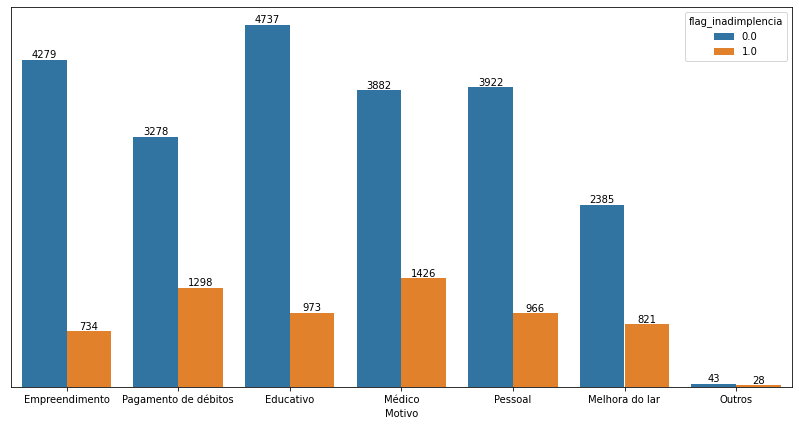

In [46]:
plt.figure(figsize=(14,7))
ax = sns.countplot(data=base_tratada, x='motivo', hue='flag_inadimplencia')
ax.get_yaxis().set_visible(False)
plt.xlabel('Motivo')
ax.bar_label(container = ax.containers[0])
ax.bar_label(container = ax.containers[1])

plt.show()

#### Pontuação

In [47]:
pd.crosstab(index = base_tratada['pontuacao'],
            columns = base_tratada['flag_inadimplencia'], 
            normalize = 'index') * 100

flag_inadimplencia,0.0,1.0
pontuacao,,
A,90.307904,9.692096
B,84.011754,15.988246
C,79.640614,20.359386
D,40.865827,59.134173
E,35.583524,64.416476
F,30.331754,69.668246
G,1.694915,98.305085


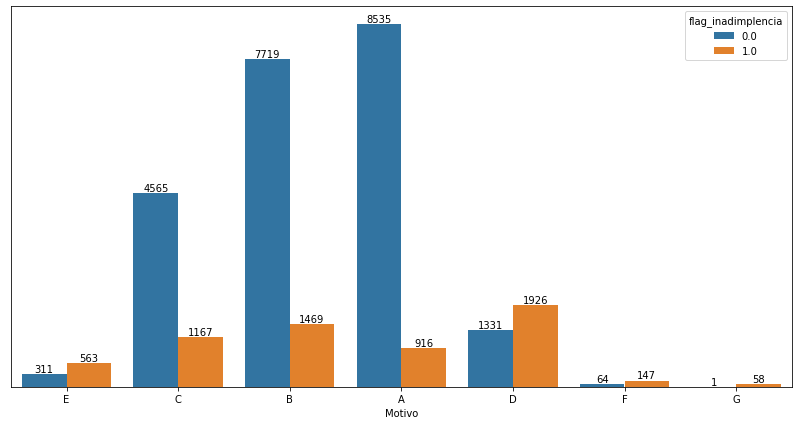

In [48]:
plt.figure(figsize=(14,7))
ax = sns.countplot(data=base_tratada, x='pontuacao', hue='flag_inadimplencia')
ax.get_yaxis().set_visible(False)
plt.xlabel('Motivo')
ax.bar_label(container = ax.containers[0])
ax.bar_label(container = ax.containers[1])

plt.show()

### Númerica

#### Idade do solicitante

<AxesSubplot:xlabel='flag_inadimplencia', ylabel='idade_solicitante'>

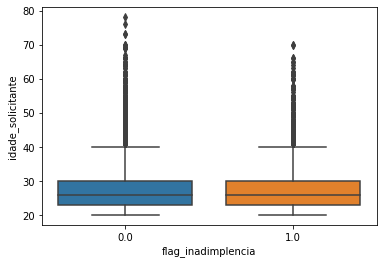

In [49]:
sns.boxplot(data=base_tratada, x='flag_inadimplencia', y='idade_solicitante')

In [50]:
base_tratada.groupby('flag_inadimplencia').describe().idade_solicitante

,count,mean,std,min,25%,50%,75%,max
flag_inadimplencia,,,,,,,,
0.0,22526.0,27.780831,6.135651,20.0,23.0,26.0,30.0,78.0
1.0,6246.0,27.451969,6.214076,20.0,23.0,26.0,30.0,70.0


#### Salário do solicitante

<AxesSubplot:xlabel='flag_inadimplencia', ylabel='salario_solicitante'>

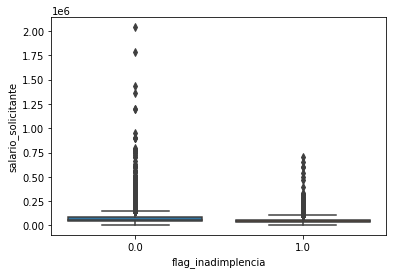

In [51]:
sns.boxplot(data=base_tratada, x='flag_inadimplencia', y='salario_solicitante')

In [52]:
base_tratada.groupby('flag_inadimplencia').describe().salario_solicitante

,count,mean,std,min,25%,50%,75%,max
flag_inadimplencia,,,,,,,,
0.0,22526.0,70907.024327,53982.140733,7200.0,42500.0,60000.0,85000.0,2039784.0
1.0,6246.0,50102.116715,36846.542936,4000.0,30000.0,42000.0,60000.0,703800.0


#### Tempo de trabalho

<AxesSubplot:xlabel='flag_inadimplencia', ylabel='tempo_trabalhado'>

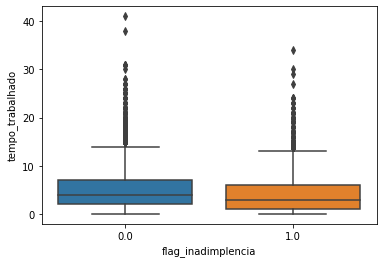

In [53]:
sns.boxplot(data=base_tratada, x='flag_inadimplencia', y='tempo_trabalhado')

In [54]:
base_tratada.groupby('flag_inadimplencia').describe().tempo_trabalhado

,count,mean,std,min,25%,50%,75%,max
flag_inadimplencia,,,,,,,,
0.0,22526.0,4.964264,4.059744,0.0,2.0,4.0,7.0,41.0
1.0,6246.0,4.120717,3.875091,0.0,1.0,3.0,6.0,34.0


#### Valor solicitado

<AxesSubplot:xlabel='flag_inadimplencia', ylabel='valor_solicitado'>

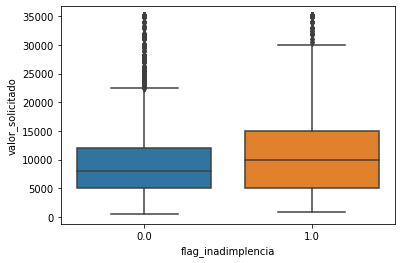

In [55]:
sns.boxplot(data=base_tratada, x='flag_inadimplencia', y='valor_solicitado')

In [56]:
base_tratada.groupby('flag_inadimplencia').describe().valor_solicitado

,count,mean,std,min,25%,50%,75%,max
flag_inadimplencia,,,,,,,,
0.0,22526.0,9276.087632,6023.141452,500.0,5000.0,8000.0,12000.0,35000.0
1.0,6246.0,11024.267531,7155.580244,900.0,5000.0,10000.0,15000.0,35000.0


#### Taxa de juros

<AxesSubplot:xlabel='flag_inadimplencia', ylabel='taxa_juros'>

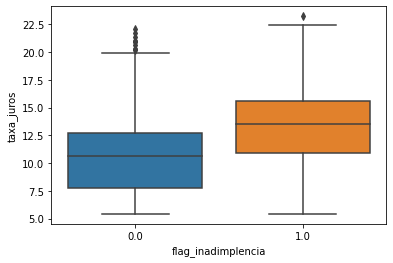

In [57]:
sns.boxplot(data=base_tratada, x='flag_inadimplencia', y='taxa_juros')

In [58]:
base_tratada.groupby('flag_inadimplencia').describe().taxa_juros

,count,mean,std,min,25%,50%,75%,max
flag_inadimplencia,,,,,,,,
0.0,22526.0,10.464154,2.972900,5.42,7.74,10.62,12.69,22.06
1.0,6246.0,13.125692,3.261211,5.42,10.91,13.49,15.58,23.22


Avaliando visualmente as proporções de inadimplência, foi possível notar os seguintes pontos de atenção:
1. Empréstimos em que o solicitante possui uma casa alugada tem maior incidência de inadimplência em relação as outras situações de imóveis.
1. A pontuação segue um padrão esperado, 'A' tem a menor quantidade de clientes inadimplentes enquanto G tem a maior
1. A taxa de juros se mostra bem maior nos clientes inadimplentes em relação aos não inadimplentes.

Antes dos tratamentos, vou exportar a base 

In [92]:
base_tratada.to_csv('../dados/base_estudo_tratada.csv', index_label=False, index=False, decimal=',')

### Correlação

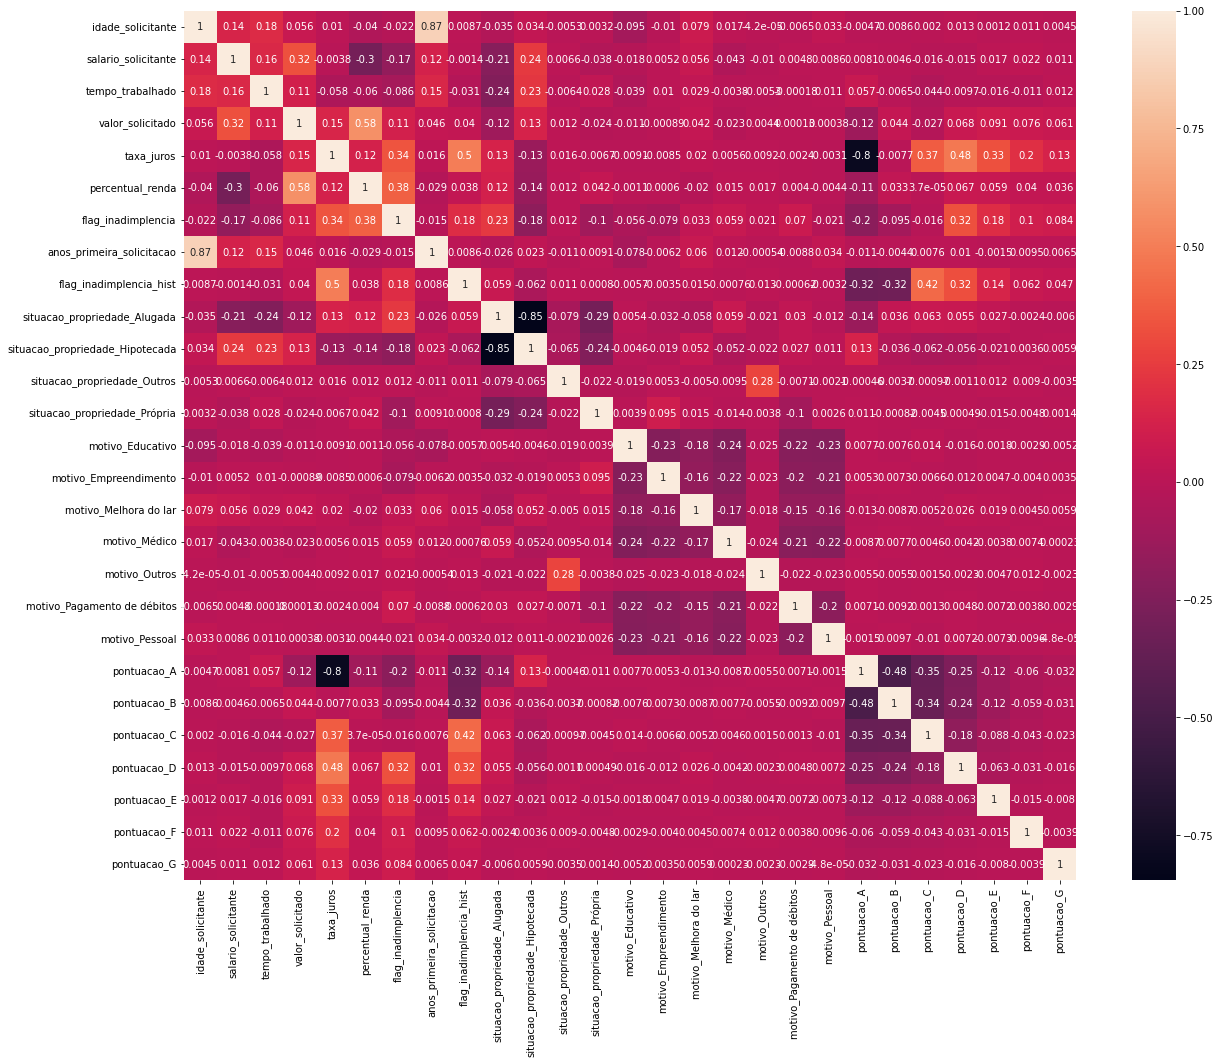

In [60]:
fig, ax = plt.subplots(figsize=(20, 16))

sns.heatmap(pd.get_dummies(base_tratada).corr(), annot=True)
plt.show()

### Transformação de colunas categóricas

Vou separar as colunas com valores categóricos em novas colunas. Para isso utilizarei o One Hot Encoder

In [61]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

Como visto, taxa de juros, propriedade alugada e pontuação 'baixa' tem maior correlação com inadimplência. Vou deletar a coluna de percentual renda pois ela nada mais é do um calculo com a taxa de juros, ou seja, redundante para o modelo.

Vamos aos modelos!

In [62]:
x = base_tratada.drop(columns=['flag_inadimplencia', 'percentual_renda'])
y = base_tratada['flag_inadimplencia']

In [63]:
colunas_categoricas = ['situacao_propriedade', 'motivo', 'pontuacao']

In [64]:
ohe = make_column_transformer(
    (OneHotEncoder(), colunas_categoricas), 
    remainder='passthrough',
    verbose_feature_names_out=False)
x = pd.DataFrame(ohe.fit_transform(x), columns = ohe.get_feature_names_out())
x.head()

,situacao_propriedade_Alugada,situacao_propriedade_Hipotecada,situacao_propriedade_Outros,situacao_propriedade_Própria,motivo_Educativo,motivo_Empreendimento,motivo_Melhora do lar,motivo_Médico,motivo_Outros,motivo_Pagamento de débitos,...,pontuacao_E,pontuacao_F,pontuacao_G,idade_solicitante,salario_solicitante,tempo_trabalhado,valor_solicitado,taxa_juros,anos_primeira_solicitacao,flag_inadimplencia_hist
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,23.0,68000.0,1.0,14400.0,17.99,2.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,25.0,45000.0,0.0,10000.0,12.98,2.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,23.0,65000.0,2.0,3600.0,11.49,2.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23.0,45312.0,3.0,13500.0,7.88,3.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,22.0,64000.0,6.0,7000.0,5.79,3.0,0.0


## Modelagem

### Etapa de pré-processamento

### Normalização

Como temos variaveis com valores bem discrepantes (salário por exemplo) iremos aplicar uma normalização a fim de evitar enviesamento do modelo que será construído

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x)

MinMaxScaler()

In [66]:
colunas = x.columns

In [67]:
x = pd.DataFrame(scaler.transform(x), columns=colunas)
x.head()

,situacao_propriedade_Alugada,situacao_propriedade_Hipotecada,situacao_propriedade_Outros,situacao_propriedade_Própria,motivo_Educativo,motivo_Empreendimento,motivo_Melhora do lar,motivo_Médico,motivo_Outros,motivo_Pagamento de débitos,...,pontuacao_E,pontuacao_F,pontuacao_G,idade_solicitante,salario_solicitante,tempo_trabalhado,valor_solicitado,taxa_juros,anos_primeira_solicitacao,flag_inadimplencia_hist
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.051724,0.031438,0.024390,0.402899,0.706180,0.000000,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.086207,0.020140,0.000000,0.275362,0.424719,0.000000,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.051724,0.029964,0.048780,0.089855,0.341011,0.000000,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.051724,0.020293,0.073171,0.376812,0.138202,0.035714,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.034483,0.029473,0.146341,0.188406,0.020787,0.035714,0.0


### Balanceamento da variável target

In [68]:
y.value_counts(normalize=True)

0.0    0.782914
1.0    0.217086
Name: flag_inadimplencia, dtype: float64

In [69]:
y.value_counts(normalize=False)

0.0    22526
1.0     6246
Name: flag_inadimplencia, dtype: int64

A base apresenta-se desbalanceada. Para resolver este problema no treinamento do modelo, iremos utilizar o método SMOTE

In [70]:
from imblearn.over_sampling import SMOTE

In [71]:
SEED = 2154
np.random.seed(SEED)

In [72]:
smote = SMOTE(random_state=SEED)

In [73]:
x_resample, y_resample = smote.fit_resample(x, y)

In [74]:
print('Saímos de {} variável target para {}'.format(y.value_counts()[1], y_resample.value_counts()[1]))

Saímos de 6246 variável target para 22526


### Separação de treino e teste

In [75]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.25, random_state=SEED)

### Modelos

#### Regressão logística

In [76]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=SEED)

#### Árvore randômica

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, random_state=SEED)

#### _Gradient Boosting_

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=SEED)

### Avaliar os modelos

Relembrando as métricas:
* **Acurácia/Accuracy**: avalia a proporção de acertos em relação a todas as previsões realizadas. É obtida somando a diagonal principal da matriz e dividindo pela soma de todos os valores.
* **Sensibilidade/Revocação/Recall**: avalia a proporção de verdadeiros positivos dentre todos os valores positivos reais. É obtida dividindo os verdadeiros positivos pela soma de positivos reais.
* **Precisão/Precision**: avalia a proporção de verdadeiros positivos dentre as predições dadas como positivas pelo modelo. É obtida dividindo os verdadeiros positivos pela soma das previsões positivas.
* **F1 Score**: é o equilíbrio entre a sensibilidade e a precisão, sendo a média harmônica entre as duas métricas. 

Fonte: [Alura](https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106629)

In [79]:
metricas = pd.DataFrame()

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

classificadores = [lr, rf, gbc]

for idx, clf in enumerate(classificadores):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    metricas.loc[idx, 'classificador'] = clf.__class__.__name__
    metricas.loc[idx, 'acuracia_teste'] = clf.score(x_test, y_test)
    metricas.loc[idx, 'acuracia_treino'] = clf.score(x_train, y_train)
    metricas.loc[idx, 'precisao'] = metrics.precision_score(y_test, y_pred)
    metricas.loc[idx, 'recall'] = metrics.recall_score(y_test, y_pred)
    metricas.loc[idx, 'f1'] = metrics.f1_score(y_test, y_pred)
    y_pred_proba = clf.predict_proba(x_test)[::, 1]
    metricas.loc[idx, 'auc'] = metrics.roc_auc_score(y_test, y_pred_proba)    
    cm = confusion_matrix(y_test, y_pred)
    metricas.loc[idx, 'matriz_confusao'] = ConfusionMatrixDisplay(confusion_matrix=cm)

In [80]:
metricas.drop(columns='matriz_confusao').style.hide_index()

classificador,acuracia_teste,acuracia_treino,precisao,recall,f1,auc
LogisticRegression,0.769955,0.771109,0.781250,0.758107,0.769504,0.845401
RandomForestClassifier,0.815768,0.812661,0.819767,0.815600,0.817679,0.882203
GradientBoostingClassifier,0.882713,0.884104,0.895240,0.870289,0.882588,0.953487


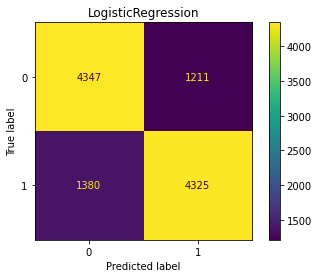

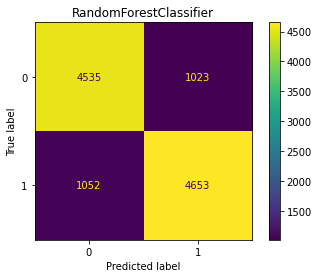

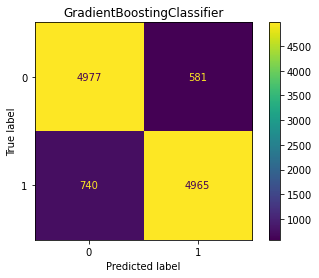

In [81]:
for idx, clf in enumerate(classificadores):
    metricas.loc[idx, 'matriz_confusao'].plot()
    plt.title(clf.__class__.__name__)

- **(0,0) Verdadeiros Negativos:** Acertou os adimplentes.
- **(0,1) Falsos Positivos:** Errou os adimplentes, marcou como inadimplente um adimplente.
- **(1,0) Falsos Negativos:** Errou os inadimplente, marcou como adimplente um inadimplente.
- **(1,1) Verdadeiros Positivos:** Acertou os inadimplente

Além dos acertos, precisamos que os Falsos Negativos sem baixos! [Fonte](https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106629)

Desta forma, avalio que o modelo de melhor desempenho é o GradientBoostingClassifier, pois além de apresentar os melhores resultados em todas as métricas, tem um baixo valor de **Falsos Positivos**

### Melhoria do modelo

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
parameters = {
    "loss":["log_loss","exponential"],
    "max_depth":[3,5,8],
    "n_estimators":[10,100],
    "criterion": ["friedman_mse",  "squared_error"],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9],
    }

In [84]:
gridsearch_cv = GridSearchCV(
    gbc, parameters, cv=3, scoring="recall", n_jobs=-1
)

In [85]:
%%time
gridsearch_cv.fit(x_train, y_train)

Wall time: 3min 17s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=2154),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [10, 100],
                         'subsample': [0.5, 0.618, 0.8, 0.85, 0.9]},
             scoring='recall')

In [86]:
gridsearch_cv.best_params_

{'criterion': 'squared_error',
 'loss': 'log_loss',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'subsample': 0.8}

In [87]:
gbc_boost = GradientBoostingClassifier(**gridsearch_cv.best_params_, random_state=SEED)

In [88]:
classificadores = [lr, rf, gbc, gbc_boost]

for idx, clf in enumerate(classificadores):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    metricas.loc[idx, 'classificador'] = clf.__class__.__name__
    metricas.loc[idx, 'acuracia_teste'] = clf.score(x_test, y_test)
    metricas.loc[idx, 'acuracia_treino'] = clf.score(x_train, y_train)
    metricas.loc[idx, 'precisao'] = metrics.precision_score(y_test, y_pred)
    metricas.loc[idx, 'recall'] = metrics.recall_score(y_test, y_pred)
    metricas.loc[idx, 'f1'] = metrics.f1_score(y_test, y_pred)
    y_pred_proba = clf.predict_proba(x_test)[::, 1]
    metricas.loc[idx, 'auc'] = metrics.roc_auc_score(y_test, y_pred_proba)    
    cm = confusion_matrix(y_test, y_pred)
    metricas.loc[idx, 'matriz_confusao'] = ConfusionMatrixDisplay(confusion_matrix=cm)

In [89]:
metricas.drop(columns='matriz_confusao').style.hide_index()

classificador,acuracia_teste,acuracia_treino,precisao,recall,f1,auc
LogisticRegression,0.769955,0.771109,0.781250,0.758107,0.769504,0.845401
RandomForestClassifier,0.815768,0.812661,0.819767,0.815600,0.817679,0.882203
GradientBoostingClassifier,0.882713,0.884104,0.895240,0.870289,0.882588,0.953487
GradientBoostingClassifier,0.935630,0.961141,0.961453,0.909378,0.934691,0.979146


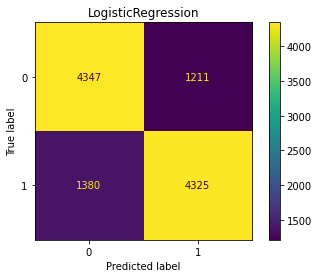

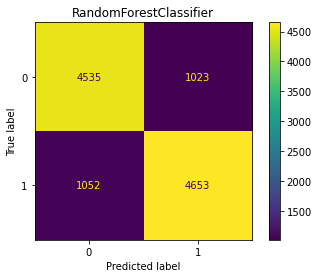

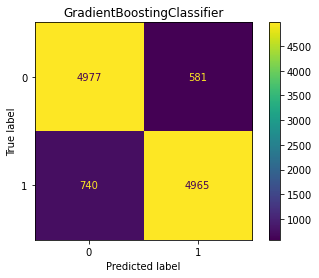

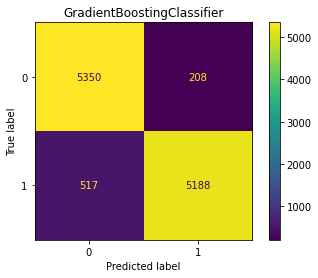

In [90]:
for idx, clf in enumerate(classificadores):
    metricas.loc[idx, 'matriz_confusao'].plot()
    plt.title(clf.__class__.__name__)

### Exportando o Modelo

In [91]:
import pickle

with open('../modelos/ohe.pkl', 'wb') as file:
    pickle.dump(ohe, file)

with open('../modelos/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    
with open('../modelos/gbc_boost.pkl', 'wb') as file:
    pickle.dump(gbc_boost, file)